# Import Modules and Load Data Set

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import spearmanr
from lightgbm import LGBMClassifier
import warnings
import pickle
%matplotlib inline
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer

In [2]:
# Upload Dataset
!wget --header="Host: doc-0s-3g-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://drive.google.com/" --header="Cookie: AUTH_6i6311e1ha4e3lu90s1q4hbjnb369mac=17867563074405901316|1647934950000|jfj1rfm9rbr6stjf3qnsnkkt67e89e3p" --header="Connection: keep-alive" "https://doc-0s-3g-docs.googleusercontent.com/docs/securesc/7jhvm23dpf0jsrpv14f2fr5ihu8tg8kq/6hdruqsjq2cvlk4p27710un90gp3bb6t/1647934950000/17867563074405901316/17867563074405901316/1O4UgcWFo84LG3Ebcr3epzCEK7-625SFS?ax=ACxEAsbkpRwTilQSkGjTTCKBZRDi4uaPj5oVlnOwdiW8Y3MS1UAGLL0diW4AJQ-XwsJCqBoyH61bbFZx-xdFQdXHDnn-4k5IR2_1lly_rf7rqm1KJ4n5O1SvFMAmz6Z1E_sFvpB-JDoFiTFUvUYopzJ_XEsfSRusmvbhSscuyJ3ru89zhoCpRYskAtprvcXOQqC6cXjvzfkgXzIQj7nwmdd1Bb_zcJE3CSJntMZf5aCeenxhoJN68-ZUPAGewOamd91Iqj_V9yDFCAzc57lxQaLJSFPVX8Au2-nHNItjr2L7NSst9XXV3FeA4LQ7hVa4_gzWYKFO2tuKHBM5Wiyef1K8yGJR-EsLd5v2qhWx1Ee-ejyN6rf45Ruw4vpobujzJAW7-88nDhfU1SxQdEgK1PvkADgkL6F0o7MCAxT-rDoafU0wVHmzz8tUDQ5p9p8GuWsJEeCT3830_QimWgwlaTlq3B-bTRvzzuISjsVLeNUFMEXwAwwawlEeaQDosKxPZGHu5qW6xcdS7Rpfc0y78Ew9bFnDGxkiXnPxckPQu6CpULG_swSKWies6aDsT7oNDr98tz5wMq3JTTk11huKrzqW_o9aQgfByzjXKG2nOShwENQgqLo0EIUf_6RkddUYR81gkfmy1qtFIH3RFH1X1CVP0DHlWKD8PggV9_DRA1oufXq3PMfqQwqgT3OG-XAM8yge8rvReh9jLeZWLbihP_NfB5RXc22JbX3HNG-iKihCkJ-90f4V8kjLda6Tgtb_S2-yGBG-Ww_grTl0VsAx3rPG20WeeAZjN8VqTUv8QwPunhJbasUcKThXZUB5wb4&authuser=0" -c -O 'complete_data.zip'

In [3]:
#Unzip Dataset
get_ipython().system_raw("unzip complete_data.zip")

# Preprocessing the Test DataSet

In [4]:
# Function to preprocess the test dataset

def Preprocessing(app_test,train_target):
  app_test_num = app_test.select_dtypes(['int','float']) #Filtering the numerical data
  app_test_cat = app_test.select_dtypes('object') #Filtering the categorical data

  #Replace outliers with NAN
  app_test_num['DAYS_EMPLOYED'].replace({365243 :np.nan}, inplace = True)
  app_test_cat['NAME_FAMILY_STATUS'].replace('Unknown', np.nan, inplace=True)
  app_test_cat['ORGANIZATION_TYPE'].replace('XNA', np.nan, inplace=True)
  app_test_cat['CODE_GENDER'].replace('XNA', np.nan, inplace=True)

  #Bureau Data
  bureau = pd.read_csv('/content/bureau.csv') #Read bureau.csv 
  bu_bal = pd.read_csv('/content/bureau_balance.csv') # Read bureau_balance.csv 
  bu_bal_dum=pd.get_dummies(bu_bal['STATUS'].astype(str)) #Create Categorical features and perform one hot encoding
  bu_bal_num=bu_bal.drop(['STATUS'],axis=1) # Filter numerical features
  bu_bal_num= pd.concat([bu_bal_num,bu_bal_dum],axis=1) # Concat both numerical and encoded categorical features 
  bu_bal_num.sort_values(by='MONTHS_BALANCE') #Sort values by Months Balance
  bu_bal_num['EWM_MONTHS_BALANCE'] = bu_bal_num['MONTHS_BALANCE'].transform(lambda x: x.ewm(alpha = 0.5).mean()) #Get Exponential Weighted Moving Average
  bu_bal_num = bu_bal_num.groupby(by = ['SK_ID_BUREAU']).mean().reset_index() 
  cat=bureau.select_dtypes('object') #Select categorical dataset
  cat_list= list(cat.columns.values) #Make a list of categorical dataset
  bureau_dum=pd.get_dummies(bureau[cat_list]) #Perform One hot Encoding on the Categorical Dataset
  bureau_num = bureau.drop(cat_list,axis=1) 
  bureau_num = pd.concat([bureau_num,bureau_dum],axis=1) #Concatenate the categorical and Numerical dataset
  bureau_num.sort_values(by='DAYS_CREDIT')
  bureau_num['EWM_DAYS_CREDIT'] = bureau_num['DAYS_CREDIT'].transform(lambda x: x.ewm(alpha = 0.8).mean()) #Get Exponential Weighted Moving Average
  bureau_num.sort_values(by='DAYS_CREDIT_ENDDATE')
  bureau_num['EWM_DAYS_CREDIT_ENDDATE'] = bureau_num['DAYS_CREDIT_ENDDATE'].transform(lambda x: x.ewm(alpha = 0.5).mean()) #Get Exponential Weighted Moving Average
  bureau_num = bureau_num.groupby(by = ['SK_ID_BUREAU']).mean().reset_index()

  count = (bureau_num.groupby(by =['SK_ID_CURR'])).count().reset_index() #Group by SK_ID_CURR and count values of SK_ID_BUREAU
  count['COUNT']=count['SK_ID_BUREAU']  
  bureau_num = bureau_num.merge(bu_bal_num, on='SK_ID_BUREAU',how='left') #Merge Bureau Balance features on Bureau features
  bureau_num = bureau_num.drop(['SK_ID_BUREAU'],axis=1) #Drop SK_ID_BUREAU
  agg1 = bureau_num.groupby(by = ['SK_ID_CURR']).min().reset_index() # Groupby SK_ID_CURR and take the min values
  agg1=agg1.rename(columns= lambda x: x+'_min' if x !='SK_ID_CURR'  else x) 
  agg2 = bureau_num.groupby(by = ['SK_ID_CURR']).max().reset_index()  # Groupby SK_ID_CURR and take the max values
  agg2=agg2.rename(columns= lambda x: x+'_max' if x !='SK_ID_CURR'  else x) 
  agg3 = bureau_num.groupby(by = ['SK_ID_CURR']).mean().reset_index() # Groupby SK_ID_CURR and take the mean of values
  agg3=agg3.rename(columns= lambda x: x+'_mean' if x !='SK_ID_CURR' else x) 

  bureau_num = agg1
  bureau_num = bureau_num.merge(agg2, on='SK_ID_CURR',how='left') # Merge the min max and mean feature together
  bureau_num = bureau_num.merge(agg3, on='SK_ID_CURR',how='left')
  bureau_num = bureau_num.merge(count[['SK_ID_CURR','COUNT']], on='SK_ID_CURR',how='left')

  bureau_num=bureau_num.rename(columns= lambda x: 'BU_'+x if x !='SK_ID_CURR' else x) #Update the name of the Features
  app_test_num = app_test_num.merge(bureau_num, on='SK_ID_CURR', how='left') #Merge the features on the SK_ID_CURR
  del bureau_num
  del bureau
  del count
  del agg1
  del agg2
  del agg3

  # Credit Card Balance

  cc_bal = pd.read_csv('/content/credit_card_balance.csv')

  cc_bal_dum=pd.get_dummies(cc_bal['NAME_CONTRACT_STATUS'])
  cc_bal_num=cc_bal.drop(['NAME_CONTRACT_STATUS'],axis=1)
  cc_bal_num= pd.concat([cc_bal_num,cc_bal_dum],axis=1)
  cc_bal_num.sort_values(by='MONTHS_BALANCE')
  cc_bal['EWM_MONTHS_BALANCE'] = cc_bal['MONTHS_BALANCE'].transform(lambda x: x.ewm(alpha = 0.5).mean())
  count = cc_bal_num.groupby(by =['SK_ID_CURR']).count().reset_index()
  count['COUNT']=count['SK_ID_PREV']

  cc_bal_num =cc_bal_num.drop(['SK_ID_PREV'],axis=1)
  agg1 = cc_bal_num.groupby(by = ['SK_ID_CURR']).min().reset_index()
  agg1=agg1.rename(columns= lambda x: x+'_min' if x !='SK_ID_CURR'  else x) 
  agg2 = cc_bal_num.groupby(by = ['SK_ID_CURR']).max().reset_index()
  agg2=agg2.rename(columns= lambda x: x+'_max' if x !='SK_ID_CURR'  else x) 
  agg3 = cc_bal_num.groupby(by = ['SK_ID_CURR']).mean().reset_index()
  agg3=agg3.rename(columns= lambda x: x+'_mean' if x !='SK_ID_CURR' else x) 

  cc_bal_num = agg1
  cc_bal_num = cc_bal_num.merge(agg2, on='SK_ID_CURR',how='left')
  cc_bal_num = cc_bal_num.merge(agg3, on='SK_ID_CURR',how='left')
  cc_bal_num = cc_bal_num.merge(count[['SK_ID_CURR','COUNT']], on='SK_ID_CURR',how='left')
  cc_bal_num =cc_bal_num.rename(columns= lambda x: 'CCB_'+x if x !='SK_ID_CURR' else x)
  app_test_num = app_test_num.merge(cc_bal_num, on='SK_ID_CURR', how='left')
  del cc_bal_num
  del cc_bal
  del count
  del agg1
  del agg2
  del agg3

  #Installment Payments

  install_pay = pd.read_csv('/content/installments_payments.csv')

  install_pay.sort_values(by='DAYS_INSTALMENT')
  install_pay['EWM_DAYS_INSTALMENT'] = install_pay['DAYS_INSTALMENT'] .transform(lambda x: x.ewm(alpha = 0.5).mean())
  install_pay.sort_values(by='DAYS_ENTRY_PAYMENT')
  install_pay['EWM_DAYS_ENTRY_PAYMENT'] = install_pay['DAYS_ENTRY_PAYMENT'] .transform(lambda x: x.ewm(alpha = 0.5).mean())

  count = install_pay.groupby(by =['SK_ID_CURR']).count().reset_index()
  count['COUNT']=count['SK_ID_PREV']

  install_pay_num =install_pay.drop(['SK_ID_PREV'],axis=1)
  agg1 = install_pay_num.groupby(by = ['SK_ID_CURR']).min().reset_index()
  agg1=agg1.rename(columns= lambda x: x+'_min' if x !='SK_ID_CURR'  else x) 
  agg2 = install_pay_num.groupby(by = ['SK_ID_CURR']).max().reset_index()
  agg2=agg2.rename(columns= lambda x: x+'_max' if x !='SK_ID_CURR'  else x) 
  agg3 = install_pay_num.groupby(by = ['SK_ID_CURR']).mean().reset_index()
  agg3=agg3.rename(columns= lambda x: x+'_mean' if x !='SK_ID_CURR' else x) 

  install_pay_num = agg1
  install_pay_num = install_pay_num.merge(agg2, on='SK_ID_CURR',how='left')
  install_pay_num = install_pay_num.merge(agg3, on='SK_ID_CURR',how='left')
  install_pay_num = install_pay_num.merge(count[['SK_ID_CURR','COUNT']], on='SK_ID_CURR',how='left')

  install_pay_num =install_pay_num.rename(columns= lambda x: 'IP_'+x if x !='SK_ID_CURR' else x)
  app_test_num = app_test_num.merge(install_pay_num, on='SK_ID_CURR', how='left')
  del install_pay_num
  del install_pay
  del count
  del agg1
  del agg2
  del agg3

  #POS Cash Balance

  pcb = pd.read_csv('/content/POS_CASH_balance.csv')

  pcb_dum=pd.get_dummies(pcb['NAME_CONTRACT_STATUS'])
  pcb_num=pcb.drop(['NAME_CONTRACT_STATUS'],axis=1)
  pcb_num= pd.concat([pcb_num,pcb_dum],axis=1)
  pcb_num.sort_values(by='MONTHS_BALANCE')
  pcb_num['EWM_MONTHS_BALANCE'] = pcb_num['MONTHS_BALANCE'].transform(lambda x: x.ewm(alpha = 0.5).mean())

  count = pcb_num.groupby(by =['SK_ID_CURR']).count().reset_index()
  count['COUNT']=count['SK_ID_PREV']

  pcb_num =pcb_num.drop(['SK_ID_PREV'],axis=1)
  agg1 = pcb_num.groupby(by = ['SK_ID_CURR']).min().reset_index()
  agg1=agg1.rename(columns= lambda x: x+'_min' if x !='SK_ID_CURR'  else x) 
  agg2 = pcb_num.groupby(by = ['SK_ID_CURR']).max().reset_index()
  agg2=agg2.rename(columns= lambda x: x+'_max' if x !='SK_ID_CURR'  else x) 
  agg3 = pcb_num.groupby(by = ['SK_ID_CURR']).mean().reset_index()
  agg3=agg3.rename(columns= lambda x: x+'_mean' if x !='SK_ID_CURR' else x) 

  pcb_num = agg1
  pcb_num = pcb_num.merge(agg2, on='SK_ID_CURR',how='left')
  pcb_num = pcb_num.merge(agg3, on='SK_ID_CURR',how='left')
  pcb_num = pcb_num.merge(count[['SK_ID_CURR','COUNT']], on='SK_ID_CURR',how='left')

  pcb_num = pcb_num.rename(columns= lambda x: 'PCB_'+x if x !='SK_ID_CURR' else x)
  app_test_num = app_test_num.merge(pcb_num, on='SK_ID_CURR', how='left')
  del pcb_num
  del pcb
  del count
  del agg1
  del agg2
  del agg3

  #Previous Application

  prev_app = pd.read_csv('/content/previous_application.csv')

  cat=prev_app.select_dtypes('object')
  cat_list= list(cat.columns.values)
  prev_app_dum=pd.get_dummies(prev_app[cat_list])

  prev_app_num = prev_app.drop(cat_list,axis=1)
  prev_app_num = pd.concat([prev_app_num,prev_app_dum],axis=1)

  count = prev_app_num.groupby(by =['SK_ID_CURR']).count().reset_index()
  count['COUNT']=count['SK_ID_PREV']

  prev_app_num = prev_app_num.drop(['SK_ID_PREV'],axis=1)
  agg1 = prev_app_num.groupby(by = ['SK_ID_CURR']).min().reset_index()
  agg1=agg1.rename(columns= lambda x: x+'_min' if x !='SK_ID_CURR'  else x) 
  agg2 = prev_app_num.groupby(by = ['SK_ID_CURR']).max().reset_index()
  agg2=agg2.rename(columns= lambda x: x+'_max' if x !='SK_ID_CURR'  else x) 
  agg3 = prev_app_num.groupby(by = ['SK_ID_CURR']).mean().reset_index()
  agg3=agg3.rename(columns= lambda x: x+'_mean' if x !='SK_ID_CURR' else x) 
 
  prev_app_num = agg1
  prev_app_num = prev_app_num.merge(agg2, on='SK_ID_CURR',how='left')
  prev_app_num = prev_app_num.merge(agg3, on='SK_ID_CURR',how='left')
  prev_app_num = prev_app_num.merge(count[['SK_ID_CURR','COUNT']], on='SK_ID_CURR',how='left')

  prev_app_num = prev_app_num.rename(columns= lambda x: 'PA_'+x if x !='SK_ID_CURR' else x)
  app_test_num = app_test_num.merge(prev_app_num, on='SK_ID_CURR', how='left')
  del prev_app_num
  del prev_app
  del count
  del agg1
  del agg2
  del agg3
 
  # Load all the trained and saved list, normalizer, encoder and model
  Mut_corr_File = open('Mut_corr_File', 'rb')     
  Mut_corr = pickle.load(Mut_corr_File)

  knn_model = open('knn_model', 'rb')     
  knn = pickle.load(knn_model)

  cat_mode_file = open('cat_mode_file', 'rb')     
  cat_mode = pickle.load(cat_mode_file)

  normalizer_file = open('normalizer_file', 'rb')     
  normalizer = pickle.load(normalizer_file)


  empty_list_File = open('empty_list_File', 'rb')     
  empty_list = pickle.load(empty_list_File)

  res_enco_file = open('res_enco_file', 'rb')     
  res_enco = pickle.load(res_enco_file)

  #Fill NAN values with Zeros in Numerical features
  for i in app_test_num.columns.values:
    if i !='TARGET' and i!='SK_ID_CURR':
      app_test_num[i].replace({np.nan:0}, inplace = True)

  #Drop Features which have single unique value
  app_test_num = app_test_num.drop(empty_list,axis=1)

  #Create New Features
  app_test_num['INSTALL_MNT'] = app_test_num['AMT_CREDIT']/(app_test_num['AMT_ANNUITY']+1)
  app_test_num['CREDIT_Income'] = app_test_num['AMT_CREDIT']/(app_test_num['AMT_INCOME_TOTAL']+1)
  app_test_num['ANNUITY_Income'] = app_test_num['AMT_ANNUITY']/(app_test_num['AMT_INCOME_TOTAL']+1)
  app_test_num['EXT_combined'] = app_test_num['EXT_SOURCE_1'] * app_test_num['EXT_SOURCE_2'] * app_test_num['EXT_SOURCE_3'] 
  app_test_num['EXT_mean'] = app_test_num[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
  app_test_num['INC_PER_CHLD'] = app_test_num['AMT_INCOME_TOTAL'] / (1 + app_test_num['CNT_CHILDREN'])
  app_test_num['EMPLOY_TO_BIRTH_RATIO'] = app_test_num['DAYS_EMPLOYED'] / (app_test_num['DAYS_BIRTH']+1)
  app_test_num['SCORES_STD'] = app_test_num[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
  app_test_num['CAR_TO_BIRTH_RATIO'] = app_test_num['OWN_CAR_AGE'] / (app_test_num['DAYS_BIRTH']+1)
  app_test_num['PHONE_TO_BIRTH_RATIO'] = app_test_num['DAYS_LAST_PHONE_CHANGE'] / (app_test_num['DAYS_BIRTH']+1)
  app_test_num['AGE_EMPLOYED'] = app_test_num['DAYS_EMPLOYED'] - app_test_num['DAYS_BIRTH']
  docs_list = [i for i in app_test_num.columns if 'FLAG_DOC' in i]
  app_test_num['DOC_IND_KURT'] = app_test_num[docs_list].kurtosis(axis=1)

 #Normalize numerical features
  for i in app_test_num.columns.values:
    if i !='TARGET' and i!='SK_ID_CURR':
      app_test_num[i] = normalizer['norm_'+i].transform(app_test_num[i].values.reshape(-1, 1))

  # Function for response Encoding
  def response_coding_transform(X,Cats_class_counts):
    class0=[]
    class1=[]
    X=np.array(X)
    for i in X:
        if i+str(1) in Cats_class_counts and i+str(0) in Cats_class_counts:
            class1.append(Cats_class_counts[i+str(1)])
            class0.append(Cats_class_counts[i+str(0)])
        if i+str(1) in Cats_class_counts and i+str(0) not in Cats_class_counts:
            class1.append(Cats_class_counts[i+str(1)])
            class0.append(0)
        if i+str(1) not in Cats_class_counts and i+str(0) in Cats_class_counts:
            class1.append(0)
            class0.append(Cats_class_counts[i+str(0)])
        if i+str(0) not in Cats_class_counts and i+str(1) not in Cats_class_counts :
            class1.append(0.5)
            class0.append(0.5)
            
    return  (np.array(class1)).reshape(-1,1)
  
  # Fill NAN values with mode of categorical features
  for i in app_test_cat.columns.values:
    if i !='TARGET' and i!='SK_ID_CURR':
      app_test_cat[i].replace({np.nan:cat_mode[i]}, inplace = True)

  # Encoding Categorical Features
  for i in app_test_cat.columns.values:
    if i !='TARGET' and i!='SK_ID_CURR':
      app_test_cat[i+str(1)] = response_coding_transform(app_test_cat[i],res_enco[i])
      app_test_cat.drop([i],axis=1,inplace=True)

  #Concat Numerical and Categorical values
  app_test = pd.concat([app_test_num,app_test_cat],axis=1)

  # Create New Features with the complete data
  app_test['EMPLOY_TO_BIRTH_RATIOFLAG_DOCUMENT_6']=app_test['EMPLOY_TO_BIRTH_RATIO']/app_test['FLAG_DOCUMENT_6']
  app_test['PA_DAYS_DECISIONPCB_Demand_mean'] =app_test['PA_DAYS_DECISION_mean']/app_test['PCB_Demand_mean']
  app_test['SCORES_STDFLAG_DOCUMENT_17'] = app_test['SCORES_STD']/app_test['FLAG_DOCUMENT_17']
  app_test['PA_NAME_YIELD_GROUP_XNAPA_CODE_REJECT_REASON_SYSTEM_mean']=  app_test['PA_NAME_YIELD_GROUP_XNA_mean']/app_test['PA_CODE_REJECT_REASON_SYSTEM_mean']
  app_test['SCORES_STDFLAG_DOCUMENT_16'] = app_test['SCORES_STD']/app_test['FLAG_DOCUMENT_16']
  app_test['EMPLOY_TO_BIRTH_RATIO_mul_FLAG_EMP_PHONE']=app_test['EMPLOY_TO_BIRTH_RATIO']/app_test['FLAG_EMP_PHONE']
  app_test['PA_NAME_CONTRACT_STATUS_Refused_meanPA_NAME_YIELD_GROUP_high_min']=app_test['PA_NAME_CONTRACT_STATUS_Refused_mean']/app_test['PA_NAME_YIELD_GROUP_high_min']

  # Drop highly correlated features
  app_test = app_test.drop(Mut_corr,axis=1)
  
  train_data_for_neighbors = app_test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','EXT_mean','INSTALL_MNT']]
  train_1000_neighbors = knn.kneighbors(train_data_for_neighbors)[1]

  #adding the standard deviation of targets of 1000 neighbors to new column
  app_test['TARGET_NEIGHBORS_1000_STD'] = [train_target['TARGET'].iloc[i].std() for i in train_1000_neighbors]
  
  # Rename features and remove special characters
  for i in app_test.columns:
    if ',' in i:
      j=i.replace(',','')
      app_test[j]=app_test[i]
      del app_test[i]
    if  ':' in i:
     j=i.replace(':','')
     app_test[j]=app_test[i]
     del app_test[i]

  return app_test


In [ ]:
# Loading data to pandas and preprocessing test data
app_test = pd.read_csv('/content/application_test.csv')
train_target = pd.read_csv('/content/application_train.csv')
test_data = Preprocessing(app_test,train_target)

In [6]:
test_data.head(1)

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,PA_PRODUCT_COMBINATION_Cash X-Sell high_max,PA_PRODUCT_COMBINATION_Cash X-Sell low_max,PA_PRODUCT_COMBINATION_Cash X-Sell middle_max,PA_NAME_TYPE_SUITE_Spouse partner_mean,PA_PRODUCT_COMBINATION_Cash Street high_mean,PA_PRODUCT_COMBINATION_Cash Street low_mean,PA_PRODUCT_COMBINATION_Cash Street middle_mean,PA_PRODUCT_COMBINATION_Cash X-Sell high_mean,PA_PRODUCT_COMBINATION_Cash X-Sell low_mean,PA_PRODUCT_COMBINATION_Cash X-Sell middle_mean
0,100001,-0.577538,-0.142533,-0.075097,-0.451692,-0.237829,-0.14591,-0.734193,-0.162177,-0.052196,...,-0.361813,-0.521722,-0.549182,-0.307961,-0.26247,-0.181791,-0.199357,-0.300583,-0.436201,-0.452033


In [7]:
test_data.shape

(48744, 865)

# Model - LGBMClassifier

In [8]:
# Loading list of selected features
selected_fea = open('selected_fea', 'rb')     
selected_features = pickle.load(selected_fea)
test_data1=test_data[selected_features]

In [9]:
test_data1.shape

(48744, 363)

In [10]:
# Loading LGBM model
Model1 = open('Model1', 'rb')     
Model1 = pickle.load(Model1)

# Prediction

In [11]:
#Predit on test data
y_test_pred=Model1.predict_proba(test_data1)[:,1]

In [12]:
# Create and dataframe with SK_ID_CURR and predicted TARGET
submission = pd.DataFrame({'SK_ID_CURR':test_data['SK_ID_CURR'].values,'TARGET':y_test_pred})

In [13]:
# Save submission to a CSV file
submission.to_csv('submission.csv', index=False)

# Result

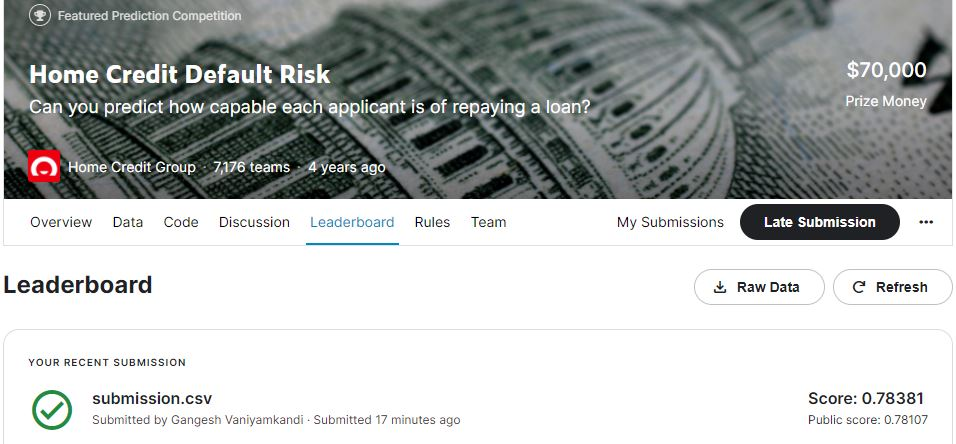

## **Got a Private Score of 0.78381 and Public score of 0.78107**